## FILE PATHS CFG

In [2]:
# PIVOT_FILE='/home/kvassay/data/sketch-testing/pivots-random-2560.data'
# DATASET_FILE='/home/kvassay/data/sketch-testing/profi-neuralnet-100K.data'
# PARTITIONER_SAVE_PATH='/home/kvassay/data/sketch-testing/models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model'
# SKETCH_PRODUCER_SAVE_PATH='/home/kvassay/data/sketch-testing/models/sketch_producer_16bit_100k_dataset.model'
# PARTITIONER_LOAD_PATH='/home/kvassay/data/sketch-testing/models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model'

#PATH_PREFIX='/Users/matejkvassay/data/sketch-testing/'
PATH_PREFIX='/home/kvassay/data/sketch-testing/'

PIVOT_FILE=PATH_PREFIX+'pivots-random-2560.data'
DATASET_FILE=PATH_PREFIX+'profi-neuralnet-100K.data'
#DATASET_LARGE_FILE=PATH_PREFIX+'profi-neuralnet-1M.data'
DATASET_LARGE_FILE=PATH_PREFIX+'profi-neuralnet-100K.data' # FOR TESTING PURPOSES
PARTITIONER_SAVE_PATH=PATH_PREFIX+'models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model'
SKETCH_PRODUCER_SAVE_PATH=PATH_PREFIX+'models/sketch_producer_32bit_100k_dataset.model'
#SKETCH_DB_SAVE_PATH=PATH_PREFIX+'sketch_db_1M.dump'
SKETCH_DB_SAVE_PATH=PATH_PREFIX+'sketch_db_32bit_100K.dump' #FOR TESTING PURPOSES




In [3]:
import logging
logger = logging.getLogger()
logger.setLevel('INFO')
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
# add the handlers to the logger
logger.addHandler(ch)
logger.info('Logger works.') #to prevent duplicate logs

2016-12-07 16:02:33,216 - root - INFO - Logger works.


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from scipy.spatial.distance import euclidean, hamming
import time
import cPickle
import random
import pandas as pd

In [5]:
def get_cfg(cfg_path_or_dict):
    if type(cfg_path_or_dict) == dict:
        return cfg_path_or_dict
    if not os.path.isfile(cfg_path_or_dict):
        raise ValueError('Config must be path to valid .yml file or dict.')
    with open(cfg_path_or_dict, 'rb') as f:
        cfg = yaml.load(f)
    return cfg

def log_pfx(obj, msg, *args):
    logger.info(obj.__class__.__name__+'| '+msg, *args)
    
def save_to(obj, file_path):
    with open(file_path, 'wb') as f:
        cPickle.dump(obj,f)

def load_from(file_path):
    with open(file_path, 'rb') as f:
        return cPickle.load(f) 

## CLASS IMPLEMENTATIONS

In [6]:
class CaffeVectorsIterator(object):
    def __init__(self, file_path, limit=None):
        log_pfx(self,'Reading Caffe Vector file %s...',file_path)
        self.f = open(file_path, 'rb')
        self.limit=limit
        if self.limit is not None:
            self.returned=0

    def next(self):
        try:
            # (id: int, vector: np array of float32)
            if self.limit is not None:
                if self.returned==self.limit:
                    self.f.close()
                    raise StopIteration
                    
            lineA = self.f.next()
            lineB = self.f.next()
            if self.limit is not None:
                self.returned+=1
                
            return (int(lineA.split(' ')[2]),  np.fromstring(lineB, dtype='f', sep=' '))
        except StopIteration:
            self.f.close()
            raise StopIteration

    def __del__(self):
        if self.f:
            self.f.close()


class CaffeVectorsIterable(object):
    def __init__(self, file_path, limit=None):
        self.file_path = file_path
        self.limit=limit

    def __iter__(self):
        return CaffeVectorsIterator(self.file_path,limit=self.limit)

In [7]:
class MultiHyperplanePartitioner(object):

    def __init__(self, cfg):
        if cfg:
            cfg = get_cfg(cfg)
            all_pivots=self.read_pivots(cfg)
            self.pivots, self.balance_score=self.select_top_k_pivots(all_pivots, int(cfg['base_sketch_length']))
            self.pivots=list(self.pivots)
            self.balance_score=list(self.balance_score)
            
    def save_self(self, file_path):
        MultiHyperplanePartitioner.save(self, file_path)
    
    @staticmethod
    def save(partitioner, file_path):
        log_pfx(None,'Persisting MultiHyperplanePartitioner to %s...',file_path)
        to_save=partitioner.pivots, partitioner.balance_score
        save_to(to_save, file_path)
        log_pfx(None,'Done...')
    
    
    @staticmethod
    def load(file_path, limit_pivots=None):
        if limit_pivots is not None:
            log_pfx(None,'Loading persisted MultiHyperplanePartitioner from %s, limiting pivots count to %s...', file_path, limit_pivots )
        else:
            log_pfx(None,'Loading persisted MultiHyperplanePartitioner from %s...',file_path)

        instance=MultiHyperplanePartitioner(None)
        tupl=load_from(file_path)
        if limit_pivots is None:
            instance.pivots=tupl[0]
            instance.balance_score=tupl[1]
        else:
            instance.pivots=tupl[0][:limit_pivots]
            instance.balance_score=tupl[1][:limit_pivots]
        instance.pivots=list(instance.pivots)
        instance.balance_score=list(instance.balance_score)
        return instance

    def select_top_k_pivots(self, all_pivots,k):
        log_pfx(self,'Selecting top %s pivots...',k)
        counters=[0]*len(all_pivots)
        n_obj=0
        t_start=time.time()
        for obj in CaffeVectorsIterable(cfg['dataset_path']):
            n_obj+=1
            if n_obj%10000==0:
                t_dur=time.time()-t_start
                t_start=time.time()
                log_pfx(self,'Adding counts for partitioning balance counter for dataset obj no. %s. Processing last 10000 objects took %ss...',n_obj,t_dur)
            for i, pivot_couple in enumerate(all_pivots):
                if self.get_partition(pivot_couple, obj)==1:
                    counters[i]+=1

        log_pfx(self,'Computing balance ratios and selecting top %s pivots...', k)
        balance_ratios=[abs(0.5-(float(count_1)/n_obj)) for i, count_1 in enumerate(counters)]
        sorted_pivots_with_ratings=sorted(zip(all_pivots, balance_ratios), key=lambda x: x[1])
        top_pivots, top_balance_score=zip(*[(tupl[0], tupl[1]) for tupl in sorted_pivots_with_ratings[:k]])
        return top_pivots, top_balance_score     

    def read_pivots(self, cfg):
        log_pfx(self,'Reading pivot file...')
        pivots = list()
        iterator = CaffeVectorsIterable(cfg['pivots_file_path']).__iter__()
        while True:
            try:
                pivot_A = iterator.next()
                pivot_B = iterator.next()
                pivots.append((pivot_A, pivot_B))
            except StopIteration:
                break
        return pivots

    def remove_pivot_couple(self, idx):
        self.pivots.pop(idx)
        self.balance_score.pop(idx)

    def get_partition(self, pivot_couple, obj):
        distance_A = euclidean(obj[1], pivot_couple[0][1]) # pairwise returns matrix
        distance_B = euclidean(obj[1], pivot_couple[1][1])
        if distance_A > distance_B:
            return 0
        else:
            return 1

    def get_partitions(self, obj):
        return np.array([self.get_partition(pivot_couple, obj) for pivot_couple in self.pivots])

In [8]:
class SketchProducer(object):
    def __init__(self, cfg, partitioner=None):
        if cfg:
            self.cfg=get_cfg(cfg)
            if partitioner is None:
                self.partitioner=MultiHyperplanePartitioner(cfg)
            else:
                self.partitioner=partitioner
            log_pfx(self,'Transforming dataset to Sketch matrix...')
            sketch_matrix=self.generate_sketch_matrix(cfg['dataset_path'])
            log_pfx(self,'Sketch Matrix constructed with shape %s...',sketch_matrix.shape)
            log_pfx(self,'Optimizing sketch length to %s...', int(cfg['desired_sketch_length']))
            #TO DO: move this logs to StatsCounter
            self.optimization_corrs=self.optimize_bit_length(sketch_matrix, int(cfg['desired_sketch_length']))

    @staticmethod
    def save(sketch_producer, file_path):
        log_pfx(None,'Persisting SketchProducer to %s....',file_path)
        to_save=sketch_producer.partitioner, sketch_producer.optimization_corrs
        save_to(to_save, file_path)
        log_pfx(None,'Done...')
        
    @staticmethod
    def load(file_path):
        log_pfx(None,'Loading persisted SketchProducer from %s...',file_path)
        instance=SketchProducer(None)
        tupl=load_from(file_path)
        instance.partitioner=tupl[0]
        instance.optimization_corrs=tupl[1]
        return instance
        
    def transform_object(self, obj):
        return obj[0], self.partitioner.get_partitions(obj)
        
    
    def transform_dataset(self, file_path, save_sketches_to=None):
        start=time.time()
        log_pfx(self, 'Tranforming data set from %s to sketches...', file_path)
        sketch_db=[self.transform_object(obj) for obj in CaffeVectorsIterable(file_path)]
        dur=time.time()-start
        log_pfx(self, 'Transformation successful. Duration: %ss...', dur)
        if save_sketches_to is not None:
            log_pfx(self,'Persisting transformed dataset to %s...', save_sketches_to)
            save_to(sketch_db, save_sketches_to)
        return sketch_db
        
    def generate_sketch_matrix(self,path):
        return np.matrix([self.partitioner.get_partitions(data_record) for data_record in CaffeVectorsIterable(path)])
            
    def remove_one_bit(self, sketch_matrix): #removes single bit that will result in best improvement of mean correlation 
        best_corr=1000
        best_idx=-1
        for i in xrange(sketch_matrix.shape[1]):
            matrix_without_col=np.delete(sketch_matrix, i, axis=1)
            mean_corr=SketchProducer.mean_couple_correlation(matrix_without_col)
            if mean_corr<best_corr:
                best_corr=mean_corr
                best_idx=i
        sketch_matrix=np.delete(sketch_matrix, best_idx, axis=1)
        self.partitioner.remove_pivot_couple(best_idx)
        return sketch_matrix, best_corr
        
    def optimize_bit_length(self, sketch_matrix, desired_sketch_len):
        log_pfx(self, 'Initiating bit removal...')
        corr_vals=list()
        corr_vals.append(SketchProducer.mean_couple_correlation(sketch_matrix))
        bits_removed=0
        t_start=time.time()
        while sketch_matrix.shape[1]>desired_sketch_len:
            if bits_removed>0 and bits_removed%5==0:
                t_dur=time.time()-t_start
                t_start=time.time()
                log_pfx(self, 'Removed %s bits. Removing last 5 bits took %ss, new correlation is %s...', bits_removed, t_dur, new_corr)
            sketch_matrix, new_corr=self.remove_one_bit(sketch_matrix)
            corr_vals.append(new_corr)
            bits_removed+=1
        log_pfx(self, 'Bits removal completed, sketch matrix now has %s columns...', sketch_matrix.shape[1])
        return corr_vals

    @staticmethod
    def mean_couple_correlation(sketch_matrix):
        corr_mtx = np.corrcoef(sketch_matrix.T) #matrix of correlations of columns of sketch matrix
        corr_vals=corr_mtx[np.triu_indices(n=corr_mtx.shape[0], m=corr_mtx.shape[1], k=1)] #list of upper triangle of corr matrix (without diagonal)
        return np.mean(np.absolute(corr_vals)) #mean of absolute value of Pearson correlation coefficients 
    
        

In [9]:
class MultiHashIndex(object):
    
    def __init__(self, database, sketch_producer, n_substr, stats_counter=None):
        #TO DO: if p/m is not possible, reduce bit count
        log_pfx(self, 'Initializing MHI...')
        self.m=n_substr
        self.sketches=dict()
        self.index=[dict() for _ in range(self.m)]
        self.insert(database, stats_counter=stats_counter)
        self.sketch_producer=sketch_producer
        
    def knn_query(self, obj, k, limit_r, stats_counter=None): #tries different range queries up to range 'limit_r'
        #note that this knn might return more than k objects and result must be further filtered from FP objects on upper level
        if limit_r >= self.m:
            raise ValueError('Maximum range (limit_r) must be lesser than number of substrings (m).')
        candidates=set()
        for r in range(1, limit+1, 1):
            candidates=candidates.union(range_query(obj, r))
            if len(candidates)>=k:
                if stats_counter is not None:
                    stats_counter.add('knn_last_r', r)
                    stats_counter.add('knn_cand_count', len(candidates))
                return candidates
        if stats_counter is not None:
            stats_counter.add('knn_last_r', limit_r)
            stats_counter.add('knn_cand_count', len(candidates))
        return candidates
    
    @staticmethod
    def hamming_dist(sketch_A,sketch_B, stats_counter=None):
        assert len(sketch_A)==len(sketch_B)
        dist=sum([abs(sketch_A[i]-sketch_B[i]) for i in range(len(sketch_A))])
        if stats_counter is not None:
            stats_counter.add('hamming_dist', dist)
        return dist
    
    def range_query(self, obj, r, stats_counter=None): 
        sketch = obj[1]
        if r >= self.m:
            raise ValueError('Range (r) must be lesser than number of substrings (m).')
        candidates=self.get_range_query_candidate_ids(sketch, stats_counter=stats_counter)
        result=set([obj_id for obj_id in candidates if \
                    MultiHashIndex.hamming_dist(sketch, self.sketches[obj_id], stats_counter=stats_counter)<=r])
        return result
    
    def get_range_query_candidate_ids(self, sketch, stats_counter=None):
        candidates=set()
        count_before_union=0
        for idx, split in enumerate(np.array_split(sketch, self.m)):
            candidates_to_add=self.get_bucket_obj_ids(idx, split)
            count_before_union+=len(candidates_to_add)
            candidates=candidates.union(candidates_to_add)
        if stats_counter is not None:
            stats_counter.add('rq_candidates_cnt', len(candidates))
            stats_counter.add('rq_candidates_before_union_cnt', count_before_union)
        return candidates
        
    def get_bucket_obj_ids(self, idx, sketch_substr):
        key=self.get_key(sketch_substr)
        if key in self.index[idx]:
            return self.index[idx][key]
        else:
            return set()
    
    def index_obj(self, idx, obj_id, sketch_substr):
        key=self.get_key(sketch_substr)
        if key in self.index[idx]:
            self.index[idx][key].add(obj_id)
        else:
            new_set=set()
            new_set.add(obj_id)
            self.index[idx][key]=new_set
        
    def insert(self, objects, stats_counter=None):
        log_pfx(self, 'Inserting sketch objects to MHI.')
        cnt_done=0
        start=time.time()
        for obj_id, sketch in db:
            self.sketches[obj_id]=sketch
            [self.index_obj(idx, obj_id, substr) for idx, substr in enumerate(np.array_split(sketch, self.m))]
            cnt_done+=1
            if cnt_done%10000==0:
                dur=time.time()-start
                log_pfx(self, 'Inserted 10000 objects to MHI. Inserting took %ss...', dur)
        log_pfx(self,'Data successfully inserted...')  
            
    
    def get_key(self,sketch_substr):
        return str(sketch_substr)
        

In [10]:
class ListStatsCounter():
    def __init__(self):
        self.stats=dict()
        
    def add(self, key, val):
        if key in self.stats:
            self.stats[key].append(val)
        else:
            self.stats[key]=[val]
        
    def to_df(self):
        return pd.DataFrame.from_dict(self.stats)

## SKETCH CREATION EXPERIMENTS

### Hyperplane partitioning

In [10]:
cfg={
    'pivots_file_path':PIVOT_FILE,
    'base_sketch_length':1280,
    'dataset_path':DATASET_FILE
}
t_start=time.time()
partitioner=MultiHyperplanePartitioner(cfg)
dur_s=time.time()-t_start
log_pfx(None,'Balanced pivot selection duration: %s', dur_s)

2016-11-30 12:55:57,253 - root - INFO - MultiHyperplanePartitioner| Reading pivot file...
2016-11-30 12:55:57,254 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/pivots-random-2560.data...
2016-11-30 12:55:59,661 - root - INFO - MultiHyperplanePartitioner| Selecting top 1280 pivots...
2016-11-30 12:55:59,662 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-11-30 13:06:59,256 - root - INFO - MultiHyperplanePartitioner| Adding counts for partitioning balance counter for dataset obj no. 10000. Processing last 10000 objects took 659.59355998s...
2016-11-30 13:17:56,087 - root - INFO - MultiHyperplanePartitioner| Adding counts for partitioning balance counter for dataset obj no. 20000. Processing last 10000 objects took 656.83122611s...
2016-11-30 13:28:50,556 - root - INFO - MultiHyperplanePartitioner| Adding counts for partitioning balance counter for datase

Peristing partitioner...

In [11]:
MultiHyperplanePartitioner.save(partitioner, PARTITIONER_SAVE_PATH)

2016-11-30 14:42:41,810 - root - INFO - NoneType| Persisting MultiHyperplanePartitioner to /home/kvassay/data/sketch-testing/models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model...
2016-11-30 14:42:45,479 - root - INFO - NoneType| Done...


#### How balanced is Hyperplane partitioning with pivot couples (ordered by balance deviation)
We randomly selected over 1200 random pivot couples and ordered them according to how balanced is the data set if we partition it with Hyperplane partitioning using these couples. Balance deviation is from 0 to 0.5, 0 being perfectly balanced, 0.5 resulting in only one partition containing all dataset objects. Deviation 0.1 means, that 40% of data set is in one partition and 60% in the other. We consider this acceptable state => it's ok to use first 128 pivots.

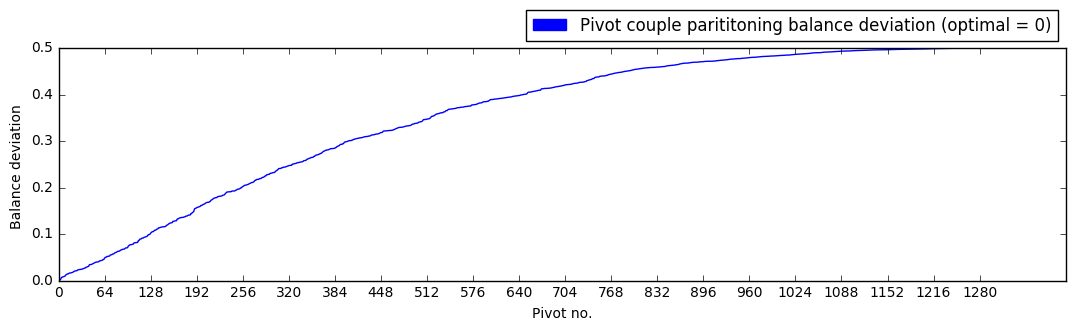

In [12]:
plt.figure(figsize=(13,3))
line=plt.plot(partitioner.balance_score, color='blue')
legend = mpatches.Patch(color='blue', label='Pivot couple parititoning balance deviation (optimal = 0)')
plt.legend(handles=[legend],bbox_to_anchor=(1, 1.2))
plt.xlabel('Pivot no.')
plt.ylabel('Balance deviation ')

plt.xticks(range(0, len(partitioner.balance_score)+1,64))
plt.show()

### Sketch matrix generation

In [13]:
cfg={
    'pivots_file_path':PIVOT_FILE,
    'base_sketch_length':128,
    'dataset_path':DATASET_FILE,
    'desired_sketch_length': 32
}

loaded_partitioner=MultiHyperplanePartitioner.load(PARTITIONER_SAVE_PATH, limit_pivots=128)

2016-11-30 14:42:46,037 - root - INFO - NoneType| Loading persisted MultiHyperplanePartitioner from /home/kvassay/data/sketch-testing/models/multihyperplanepartitioner_100k_dataset_1280_pivot_couples.model, limiting pivots count to 128...


#### Bit partitioning balance deviation for 128 bits.

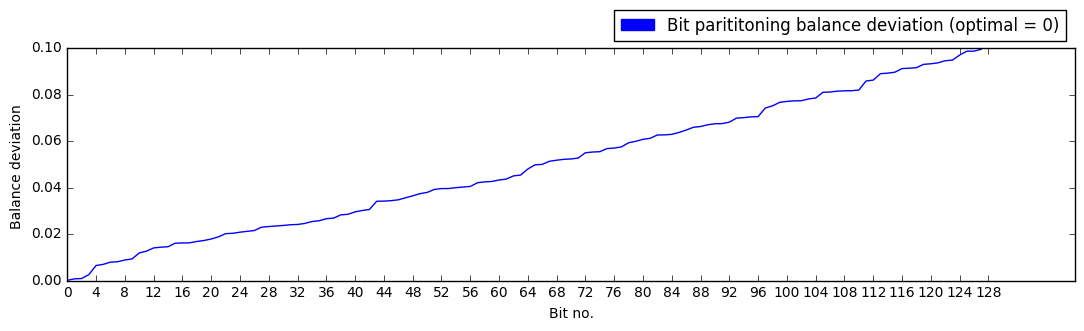

In [14]:
plt.figure(figsize=(13,3))
line=plt.plot(loaded_partitioner.balance_score, color='blue')
legend = mpatches.Patch(color='blue', label='Bit parititoning balance deviation (optimal = 0)')
plt.legend(handles=[legend],bbox_to_anchor=(1, 1.2))
plt.xlabel('Bit no.')
plt.ylabel('Balance deviation ')

plt.xticks(range(0, len(loaded_partitioner.balance_score)+1,4))
plt.show()

In [15]:
sketch_producer=SketchProducer(cfg,partitioner=loaded_partitioner)

2016-11-30 14:42:53,604 - root - INFO - SketchProducer| Transforming dataset to Sketch matrix...
2016-11-30 14:42:53,605 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-11-30 14:54:55,681 - root - INFO - SketchProducer| Sketch Matrix constructed with shape (100000, 128)...
2016-11-30 14:54:55,682 - root - INFO - SketchProducer| Optimizing sketch length to 32...
2016-11-30 14:54:55,684 - root - INFO - SketchProducer| Initiating bit removal...
2016-11-30 14:56:39,309 - root - INFO - SketchProducer| Removed 5 bits. Removing last 5 bits took 103.487851143s, new correlation is 0.272552159911...
2016-11-30 14:58:10,746 - root - INFO - SketchProducer| Removed 10 bits. Removing last 5 bits took 91.4368419647s, new correlation is 0.261042152958...
2016-11-30 14:59:31,639 - root - INFO - SketchProducer| Removed 15 bits. Removing last 5 bits took 80.8933119774s, new correlation is 0.249680506945...
2016-11-30 15:0

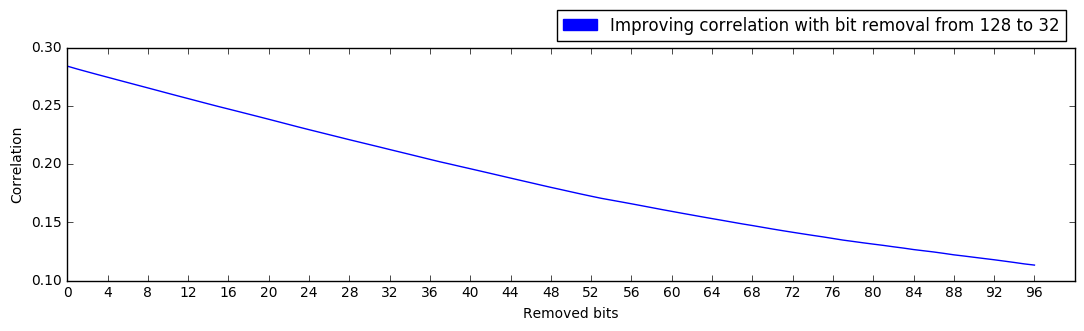

In [16]:
plt.figure(figsize=(13,3))
line=plt.plot(sketch_producer.optimization_corrs, color='blue')
legend = mpatches.Patch(color='blue', label='Improving correlation with bit removal from 128 to 32')
plt.legend(handles=[legend],bbox_to_anchor=(1, 1.2))
plt.xlabel('Removed bits')
plt.ylabel('Correlation')
xt=[num for num in range(0,len(sketch_producer.optimization_corrs)+1,4)]
#xt=[128-num for num in range(0,len(sketch_producer.optimization_corrs)+1,4)]#[::-1]
plt.xticks(xt)
plt.gca().set_xticklabels(xt)
plt.show()

In [17]:
SketchProducer.save(sketch_producer, SKETCH_PRODUCER_SAVE_PATH)

2016-11-30 15:08:20,205 - root - INFO - NoneType| Persisting SketchProducer to /home/kvassay/data/sketch-testing/models/sketch_producer_32bit_100k_dataset.model....
2016-11-30 15:08:20,333 - root - INFO - NoneType| Done...


In [18]:
#TO DO: Evaluate Correlations and Balance deviation on whole 1M dataset.

### Transform dataset to Sketches and Persist

In [19]:
sk_producer=SketchProducer.load(SKETCH_PRODUCER_SAVE_PATH)

2016-11-30 15:08:20,371 - root - INFO - NoneType| Loading persisted SketchProducer from /home/kvassay/data/sketch-testing/models/sketch_producer_32bit_100k_dataset.model...


In [20]:
_ = sk_producer.transform_dataset(DATASET_LARGE_FILE, save_sketches_to=SKETCH_DB_SAVE_PATH)

2016-11-30 15:08:20,556 - root - INFO - SketchProducer| Tranforming data set from /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data to sketches...
2016-11-30 15:08:20,558 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-11-30 15:12:19,190 - root - INFO - SketchProducer| Transformation successful. Duration: 238.634086132s...
2016-11-30 15:12:19,191 - root - INFO - SketchProducer| Persisting transformed dataset to /home/kvassay/data/sketch-testing/sketch_db_32bit_100K.dump...


## SKETCH SEARCHING EXPERIMENTS

In [11]:
sk_producer=SketchProducer.load(SKETCH_PRODUCER_SAVE_PATH)
db=load_from(SKETCH_DB_SAVE_PATH)

2016-12-07 16:18:41,419 - root - INFO - NoneType| Loading persisted SketchProducer from /home/kvassay/data/sketch-testing/models/sketch_producer_32bit_100k_dataset.model...


In [12]:
mhis=[MultiHashIndex(db, sk_producer, m) for m in range(1,9,1)]


2016-12-07 16:18:47,549 - root - INFO - MultiHashIndex| Initializing MHI...
2016-12-07 16:18:47,550 - root - INFO - MultiHashIndex| Inserting sketch objects to MHI.
2016-12-07 16:18:50,646 - root - INFO - MultiHashIndex| Inserted 10000 objects to MHI. Inserting took 3.0949420929s...
2016-12-07 16:18:53,942 - root - INFO - MultiHashIndex| Inserted 10000 objects to MHI. Inserting took 6.39154410362s...
2016-12-07 16:18:57,302 - root - INFO - MultiHashIndex| Inserted 10000 objects to MHI. Inserting took 9.75117993355s...
2016-12-07 16:19:00,604 - root - INFO - MultiHashIndex| Inserted 10000 objects to MHI. Inserting took 13.0535199642s...
2016-12-07 16:19:03,888 - root - INFO - MultiHashIndex| Inserted 10000 objects to MHI. Inserting took 16.3369860649s...
2016-12-07 16:19:07,299 - root - INFO - MultiHashIndex| Inserted 10000 objects to MHI. Inserting took 19.7486181259s...
2016-12-07 16:19:10,430 - root - INFO - MultiHashIndex| Inserted 10000 objects to MHI. Inserting took 22.879199028s.

In [13]:
def stats_list_to_pandas(keys, stats):
    return pd.DataFrame.from_dict({key: stats[key] for key in keys})

def stats_single_to_pandas(key, stats):
    return pd.Series(stats[key])

In [25]:
def bucket_count_stats(mhi):
    stats_counter=ListStatsCounter()
    bucket_obj_cnt=list()
    for index in mhi.index:
        for bucket in index:
            bucket_obj_cnt.append(len(index[bucket]))
    stats_counter.stats['sum_bucket_size']=sum(bucket_obj_cnt)
    stats_counter.stats['mean_bucket_size']=np.mean(bucket_obj_cnt)
    stats_counter.stats['bucket_sizes']=bucket_obj_cnt
    stats_counter.stats['bucket_count']=len(bucket_obj_cnt)
    return stats_counter.stats

In [33]:
def get_rq_stats(test_obj_iter, mhi, r):
    stats_counter=ListStatsCounter()
    
    for test_obj in test_obj_iter:
        sketch_obj=sk_producer.transform_object(test_obj)
        mhi.range_query(sketch_obj, r, stats_counter=stats_counter)
    stats_counter.stats['mean_rq_candidates_cnt']=np.mean(stats_counter.stats['rq_candidates_cnt'])
    stats_counter.stats['mean_rq_candidates_before_union_cnt']=np.mean(stats_counter.stats['rq_candidates_before_union_cnt'])
    return stats_counter.stats

## Stats

In [61]:
iterator=CaffeVectorsIterable(DATASET_FILE, limit=1000)
stats_bucket=[bucket_count_stats(mhi) for mhi in mhis]
stats_rq=[get_rq_stats(iterator, mhi, mhi.m-1) for mhi in mhis]
stats={ 
        'm':list(),'mean_bucket_size':list(),
        'bucket_count':list(),
        'mean_bucket_card_m_sum':list(),
        'max_r':list(),
        'sum_bucket_size':list(),
        'mean_rq_candidates_cnt':list(),
        'mean_rq_candidates_before_union_cnt':list()
      }

for idx,st in enumerate(stats_bucket):
    stats['m'].append(mhis[idx].m)
    stats['max_r'].append(mhis[idx].m-1)
    stats['mean_bucket_size'].append(st['mean_bucket_size'])
    stats['bucket_count'].append(st['bucket_count'])
    stats['mean_bucket_card_m_sum'].append(mhis[idx].m*st['mean_bucket_size'])
    stats['sum_bucket_size'].append(st['sum_bucket_size'])
    stats['mean_rq_candidates_cnt'].append(stats_rq[idx]['mean_rq_candidates_cnt'])
    stats['mean_rq_candidates_before_union_cnt'].append(stats_rq[idx]['mean_rq_candidates_before_union_cnt'])

df=stats_list_to_pandas(stats.keys(), stats)

2016-12-07 18:05:38,377 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-12-07 18:05:41,429 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-12-07 18:05:45,449 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-12-07 18:06:01,720 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-12-07 18:06:52,176 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-12-07 18:09:10,729 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...
2016-12-07 18:14:14,303 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/

In [64]:
def percentage(part, whole):
    return 100 * float(part)/float(whole)
df['mean_bucket_card_sum_percent']=df['mean_bucket_card_m_sum'].apply(lambda x: percentage(x,100000))
df['rq_union_reduced_cnt']=df.apply(lambda x: x['mean_rq_candidates_before_union_cnt']-x['mean_rq_candidates_cnt'], axis=1)
df.reindex_axis(['m','max_r', 'bucket_count','mean_bucket_size', 'sum_bucket_size','mean_bucket_card_m_sum', 'mean_bucket_card_m_sum_percent'], axis=1)

,m,max_r,bucket_count,mean_bucket_size,sum_bucket_size,mean_bucket_card_m_sum,mean_bucket_card_m_sum_percent
0,1,0,96658,1.034576,100000,1.034576,NaN
1,2,1,52235,3.828850,200000,7.657701,NaN
2,3,2,5083,59.020264,300000,177.060791,NaN
3,4,3,1024,390.625000,400000,1562.500000,NaN
4,5,4,448,1116.071429,500000,5580.357143,NaN
5,6,5,256,2343.750000,600000,14062.500000,NaN
6,7,6,176,3977.272727,700000,27840.909091,NaN
7,8,7,128,6250.000000,800000,50000.000000,NaN


#### Candidate set size
In table below we can observe, that buckets we access are actually more likely to be larger than mean size of bucket. That might be caused by fact, that objects from given distribution will more likely fall into more populated buckets.
We can also abserve, that union of buckets for result doesn't reduce number of candidates by significant amount. We would expect otherwise.

In [65]:
df.reindex_axis(['m','max_r', 'mean_rq_candidates_cnt','mean_rq_candidates_before_union_cnt', 'mean_bucket_card_m_sum', 'rq_union_reduced_cnt'], axis=1)

,m,max_r,mean_rq_candidates_cnt,mean_rq_candidates_before_union_cnt,mean_bucket_card_m_sum,rq_union_reduced_cnt
0,1,0,1.132,1.132,1.034576,0.000
1,2,1,47.246,48.378,7.657701,1.132
2,3,2,718.601,729.722,177.060791,11.121
3,4,3,2961.825,3085.879,1562.500000,124.054
4,5,4,8677.082,9434.257,5580.357143,757.175
5,6,5,19320.288,22428.411,14062.500000,3108.123
6,7,6,32325.627,41166.762,27840.909091,8841.135
7,8,7,43529.436,60958.669,50000.000000,17429.233


### Candidate set sizes comparison
This visualization shows, that sum of cardinality of selected buckets without union is actually larger than m*sum of mean bucket size. This might be happening, when query objects are from the same distribution as databse objects.

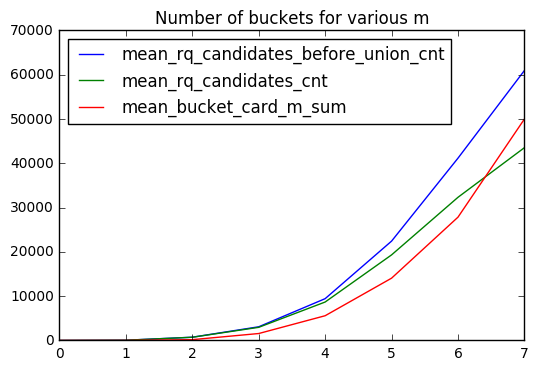

In [68]:
df[['mean_rq_candidates_before_union_cnt','mean_rq_candidates_cnt','mean_bucket_card_m_sum']].plot()
plt.title('Number of buckets for various m')

### Bucket count

Count of buckets has upper limit N - database size and lower bound u - number of unique Sketches in database.

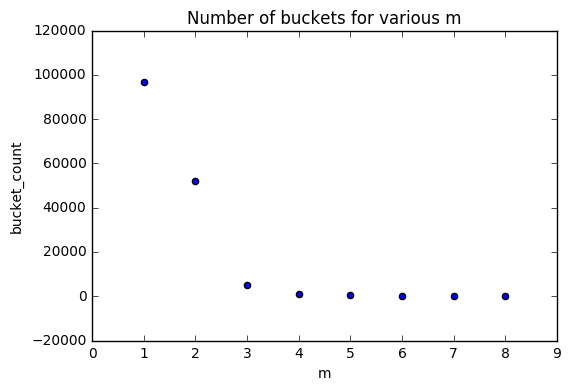

In [18]:
df.plot(x='m',y='bucket_count', kind='scatter')
plt.title('Number of buckets for various m')

### Count Object ID's stored in index
This is sum of counts of items in each bucket. It affects insertion complexity and storage requirements for the index. We can observe that storage requirement icrease is linear to m. Storage complexity is N + m*N where N is number of objects in the database.

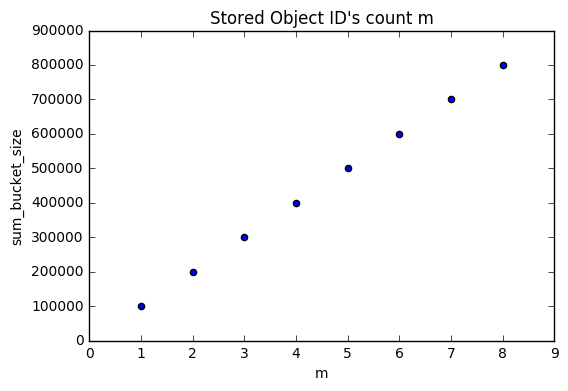

In [19]:
df.plot(x='m',y='sum_bucket_size', kind='scatter')
plt.title('Stored Object ID\'s count m')

### Mean count of Object ID's stored in single bucket

Lower mean bucket size results in smaller range query candidate set which needs to be filtered from False Positives computing hamming distance.

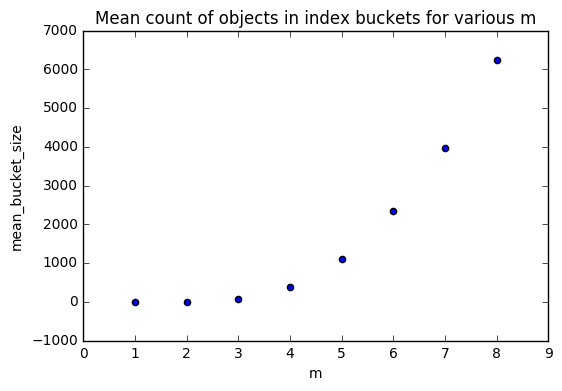

In [20]:
df.plot(x='m',y='mean_bucket_size', kind='scatter')
plt.title('Mean count of objects in index buckets for various m')

### Expected upper bound range query candidates count
In each range query we are guaranteed to visit exactly m buckets. Objects in these buckets are candidates for being at most r distant from query object. However these sets overlap so after union final candidate set might be smaller than sum of cardinalities of these buckets. But we can interpret this sum as Expected upper bound of range query candidate set.

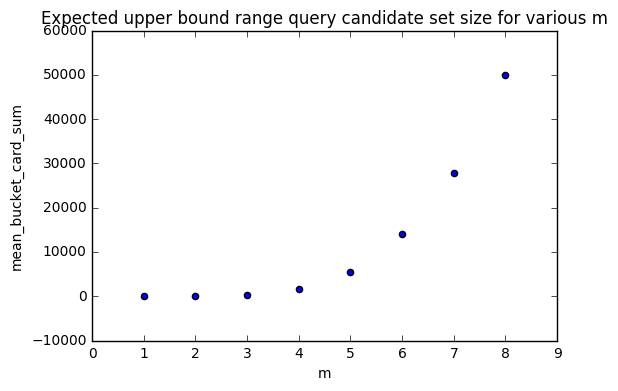

In [21]:
df.plot(x='m',y='mean_bucket_card_sum', kind='scatter')
plt.title('Expected upper bound range query candidate set size for various m')

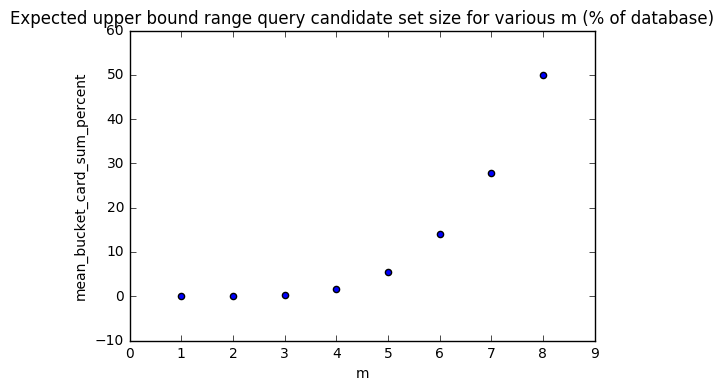

In [22]:
df.plot(x='m',y='mean_bucket_card_sum_percent', kind='scatter')
plt.title('Expected upper bound range query candidate set size for various m (% of database)')

### MHI Range query test

In [ ]:
stats_counter.add('rq_candidates_cnt', len(candidates))
stats_counter.add('rq_candidates_before_union_cnt', count_before_union)

In [ ]:
ITERATOR=CaffeVectorsIterable(DATASET_FILE, limit=100)
stats={'m':list()}
#maximal range query
for i in range(len(mhis)):
    idx=mhis[i]
    r=mhis[i].
    stats=get_rq_stats(iterator, idx, r)

In [428]:
iterator=CaffeVectorsIterable(DATASET_FILE, limit=100)
idx=mhis[4]
r=3
stats=get_rq_stats(iterator, idx, r)

2016-12-07 14:09:44,306 - root - INFO - CaffeVectorsIterator| Reading Caffe Vector file /home/kvassay/data/sketch-testing/profi-neuralnet-100K.data...


#### Range query stats